# Quantum Recurrent Neural Network Simulation

## Quantum Robotics Application - Decision Problem


The current notebook implements experimentally Gonçalves (2017)'s work on quantum neural machine learning, with quantum unitary backpropagation implemented through quantum recurrent neural networks (QRNNs) and apply it to a decision problem in the context of quantum robotics worked in Gonçalves (2019a,b).


In the problem addressed below, using Qiskit, a quantum robot has to decide between two alternative actions, receiving a corresponding utility value, the robot's quantum neural network processing must lead to the optimal decision. The general basis for the algorithm was introduced in Gonçalves (2017) and expanded upon in Gonçalves (2019a,b), we provide for a full explanation of the algorithm for the problem in the article "The Race for Quantum Supremacy and the Quantum Artificial Intelligence of Things" (https://www.academia.edu/43695119/The_Race_for_Quantum_Supremacy_and_the_Quantum_Artificial_Intelligence_of_Things), the comments to the code and the explanation cells in the current notebook provide added elements.

The main references for the current notebook are:

-  Gonçalves, C.P. (2017). "Quantum Neural Machine Learning: Backpropagation and Dynamics". NeuroQuantology, vol.15, no.1, 22-41 (https://neuroquantology.com/index.php/journal/article/view/1008/814). Research Areas: Quantum Machine Learning and Complex Quantum Systems Science.

-  Gonçalves, C.P. (2019a). "Quantum Robotics, Neural Networks and The Quantum Force Interpretation". NeuroQuantology, vol.17, no.2, 33-55 (https://www.neuroquantology.com/index.php/journal/article/view/1969/1329). Research Areas: Quantum Machine Learning and Complex Quantum Systems Science.

- Gonçalves, C.P. (2019b). Quantum Neural Machine Learning - Theory and Experiments. In Aceves-Fernandez, M.A. (ed.), Machine Learning in Medicine and Biology, IntechOpen, DOI: 10.5772/intechopen.84149, http://mts.intechopen.com/articles/show/title/quantum-neural-machine-learning-theory-and-experiments.

- Gonçalves, C.P. (2020). The Race for Quantum Supremacy and the Quantum Artificial Intelligence of Things. https://www.academia.edu/43695119/The_Race_for_Quantum_Supremacy_and_the_Quantum_Artificial_Intelligence_of_Things


In [3]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
import numpy as np
# Loading your IBM Q account(s)
provider = IBMQ.load_account()

There are two functions, the get_rnn function which defines the parametrized adaptive gates and returns the quantum recurrent neural network, the run_rnn function that runs the program.

In [4]:
def get_rnn(utility_0, utility_1):
    decision = QuantumRegister(1,'decision') # decision neuron
    evaluation = QuantumRegister(1,'evaluation') # evaluation neuron
    action = ClassicalRegister(1,'action') # action classical register
    
    # 1. Setup the quantum circuit elements
    RNN = QuantumCircuit() # quantum recurrent neural network
    RNN.add_register(decision) # add the decision neuron
    RNN.add_register(evaluation) # add the evaluation neuron
    RNN.add_register(action) # add the action register
    
    # 2. Build the quantum adaptive circuit
    
    # Feedforward stage
    
    RNN.h(decision) # explore the two decisions
    RNN.cx(decision,evaluation) # feedforward the possible alternative decisions to the evaluation neuron
    RNN.barrier([decision,evaluation]) # barrier separating the feedforward stage
    
    # Backpropagation stage
    
    if utility_1 - utility_0 > 0: # get the f function for the adaptive gate parameter
        f = 1
    else:
        f = 0
    
    RNN.ry(f*np.pi,evaluation) # adaptive rotation gate for the utility evaluation of the alternatives
    RNN.cx(evaluation,decision) # CNOT gate for backpropagation, using the network's recurrent structure
    
    RNN.barrier([decision,evaluation]) # barrier separating the backpropagation stage
    
    RNN.measure(decision,action) # measure the decision (translates into an action)
    
    # 3. Return the RNN for simulation
    return RNN

    
def run_rnn(RNN,
            backend='qasm_simulator',
            num_shots=1000):
    
    # Get the backend
    if backend == 'qasm_simulator':
        device = Aer.get_backend(backend) # use Aer if the backend is the 'qasm_simulator' (default)
    else:
        device = provider.get_backend(backend) # use the provider otherwise
    
    # Execute the circuit on the device for the number of shots defined
    job = execute(RNN, device, shots=num_shots)
    
    # Get the simulation results for the repeated experiments
    result = job.result()
    
    # Extract the counts, print them and return them for further processing
    counts = result.get_counts(RNN)
    
    # Get the decision
    
    keys = counts.keys() # we'll use the keys to get the robot to tell us what was the final decision
    
    if backend == 'qasm_simulator': # the "qasm_simulator" will alwas reach a definite decision (no noise)
        if '0' in keys: # if '0' is in the keys we know that '1' is not
            print("I'll implement action 0") # the robot tells us that it will implement 'action 0'
        else:
            print("I'll implement action 1") # the robot tells us that it will implement 'action 1'
    
    else: # in the actual device there is noise
        
        # we need the proportion of cases where the robot chose to implement 'action 1'
        p_1 = counts['1'] / (counts['0']+counts['1']) 
        
        # we need the proportion of cases where the robot chose to implement 'action 0'
        p_0 = 1-p_1
        
        if p_0 > 0.5:
            # if action 0 is dominant the robot communicates that 'action 0' will be implemented
            print("I'll implement action 0")
            print("p_0", p_0)
        elif p_1 > 0.5:
            # if action 1 is dominant the robot communicates that 'action 1' will be implemented
            print("I'll implement action 1")
            print("p_1", p_1)
    # return counts for further processing
    return counts

Let us run, on the simulator, the case where 'action 0' has a utility of 1 and 'action 1' has the utility of -1, the optimal decision in this case is 'action 0'.

I'll implement action 0


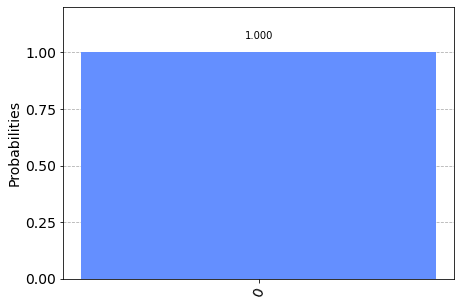

In [8]:
Net = get_rnn(utility_0=1, utility_1=-1)

counts = run_rnn(Net)

plot_histogram(counts)

To see what's happening, let us draw the circuit for this network.

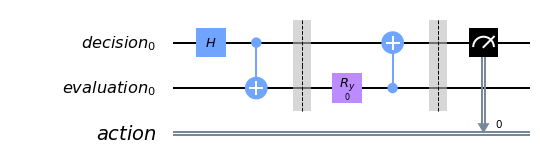

In [10]:
Net.draw()

In the first section of the circuit (the feedforward section), the decision neuron undergoes a Haddamard transform, which corresponds to a first step where both alternatives are equally weighed by the robot's artificial neural network, in the next step the two alternative decisions are fed forward to the evaluation neuron, through a CNOT gate, so that the two neurons become entangled, this is the feedforward section of the quantum neural processing, under which the quantum parallelism allows the robot to address both alternatives simultaneously.

In the second section (the backpropagation section) the evaluation neuron undergoes an Ry rotation, if we look carefully at the Qiskit code we can see that the rotation angle is dependent upon the utility difference between both alternatives, translated to an indicator function f that is equal to 1 if the utility difference between "action 1" and "action 0" is positive and zero otherwise. In the above case, since the utility difference is favorable to "action 0", the evaluation neuron will reflect this point and the rotation angle will be equal to 0 (this will change in the next experiment). The second step, after the evaluation, is the backpropagation, by which a CNOT gate is now applied on the decision neuron conditional on the evaluation neuron.

Computationally, the backpropagation is such that the second neuron is used by the neural network to conditionally correct the decision neuron, so that the optimal decision is always chosen, a point addressed in Gonçalves (2017).

In the third section (the measurement section) the decision neuron is measured, which leads to a record of the final decision, which, in this case, is 0, that is, to implement "action 0".

Let us now run the experiment, with the utility of "action 0" set to -1 and the utility of "action 1" set to 1.


I'll implement action 1


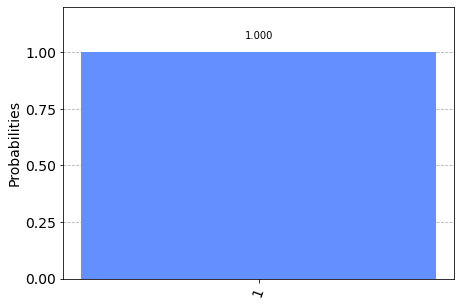

In [12]:
Net = get_rnn(utility_0=-1, utility_1=1)

counts = run_rnn(Net)

plot_histogram(counts)

Looking at the circuit, as we did in the previous experiment, we get:

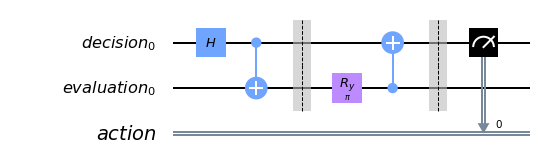

In [13]:
Net.draw()

The circuit has the same structure as the previous one, with one exception: the rotation angle for the evaluation neuron is now equal to "pi", which occurs since the utility for "action 1" is higher than the utility for "action 0".

As in  the previous case, the backpropagation is such that the second neuron is used by the neural network to conditionally correct the decision neuron, so that the optimal decision is always chosen, in this new experiment, however, it is the decision to implement "action 1" that is the optimal decision.

In the third section (the measurement section) the decision neuron is measured, which leads to a record of the final decision, which, in this case, is 1, that is, to implement "action 1".

We now run the experiments on the 'ibmq_burlington' device.

I'll implement action 0
p_0 0.8343505859375


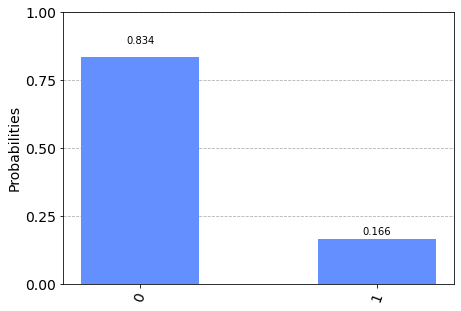

In [17]:
Net = get_rnn(utility_0=1, utility_1=-1)


counts = run_rnn(Net,
                 backend='ibmq_burlington',
                 num_shots=8192)

plot_histogram(counts)

I'll implement action 1
p_1 0.8050537109375


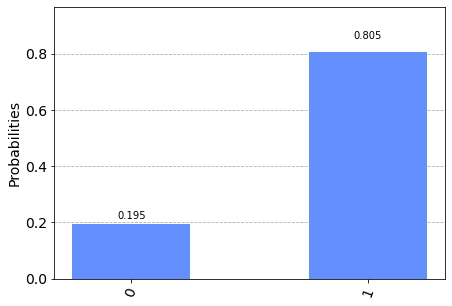

In [18]:
Net = get_rnn(utility_0=-1, utility_1=1)


counts = run_rnn(Net,
                 backend='ibmq_burlington',
                 num_shots=8192)

plot_histogram(counts)

When we run the experiments in the Burlington device we can see that in both cases the optimal decision is measured in more than 80% of the cases (there is some noise). In this case, we programmed the robot so that it runs the multiple simulations on its artificial neural network and outputs the decision most frequently measured, which explains why the robot states the correct decision and outputs the corresponding probability.